## Calibrating Trip Mode Choice
This script will iteratively perform updates to the trip mode choice coefficients config file in order to match model outputs to calibration targets.

### Load Libraries

In [1]:
import pandas as pd
import numpy as np
import os
import shutil
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from IPython.display import display
import importlib
import asim_trip_calib_util
importlib.reload(asim_trip_calib_util)
from asim_trip_calib_util import *
# import asim_calib_util
# check to make sure the dictionaries specifying names for calibration targets and activitysim outputs are consistent
check_input_dictionaries_for_consistency()

No problems found in input dictionaries


### Required Inputs
This script requires a working version of ActivitySim installed in the conda environment.  Input data sources are:
* Initial model output directory that includes household and tour files
* tour mode choice calibration target tables. Tables should be indexed by tour mode and columns should be auto sufficiency.  Tables should be broken down by tour purpose
* Model config directory containing the tour mode choice coefficients

Changes in tour modes and purposes can be implemented by changing the dictionaries at the top of asim_calib_util.py

In [2]:
# csv file containing calibration targets by tour mode choice.
# Column names and acceptable values should be set in dict at top of script
trip_mode_choice_calib_targets_file = r"E:\Met_Council\survey_data\Phase2\obs_processing\output\trip_mode_choice_calibration_targets.csv"

# location of configuration files
configs_dir = r"E:\Met_Council\metc-asim-model\source\activitysim\configs"
configs_mp_dir = None
data_dir = r"E:\Met_Council\metc-asim-model\calibration\trip_mode\data" #FIXME

warm_start_settings_file = r"C:\projects\Gen3_Model\calibration\trip_mode\\configs\settings_warm_start.yaml"
warm_start_settings_mp_file = r"C:\projects\Gen3_Model\calibration\trip_mode\configs\settings_mp_warm_start.yaml"
cold_start_settings_mp_file = r"C:\projects\Gen3_Model\calibration\trip_mode\configs\settings_mp_cold_start.yaml"
trip_mc_coef_file = None # if None, uses tour mode choice coefficient file in configs_dir
# tour_mc_coef_file = r"E:\Projects\Clients\SEMCOG\Models\SEMCOG_TDM\ABM\Model_Runs\university_enhacements\trip_mode_choice_calib\calibration_iter_1_3\trip_mode_choice_coefficients.csv"

# output location
# output_dir = r"E:\Projects\Clients\SEMCOG\Tasks\Task10_Calibration\TripModeChoice\Output\100k\trip_mc_output_100k"
output_dir = r"E:\Met_Council\metc-asim-model\Base_2022\activitysim\output"
activitysim_run_dir = r"C:\RSG_test\semcog\Tasks\Tour_mc_calib\asim_run_dir"

# calibration iterations
calibration_iterations_to_run = 3

# want to do intial model run first?
want_to_do_initial_model_run = True  # True or False

# calibration settings
max_ASC_adjust = 3 # maximum allowed adjustment per iteration
damping_factor = 0.75 # constant multiplied to all adjustments
adjust_when_zero_counts = 2 # coefficient change when have target counts but no model counts (or vise-versa)



--------------- User should not have to change anything below this line ----------------------

# Initial Status

Sample rate of  1 results in  13056109 out of 13056109 tours


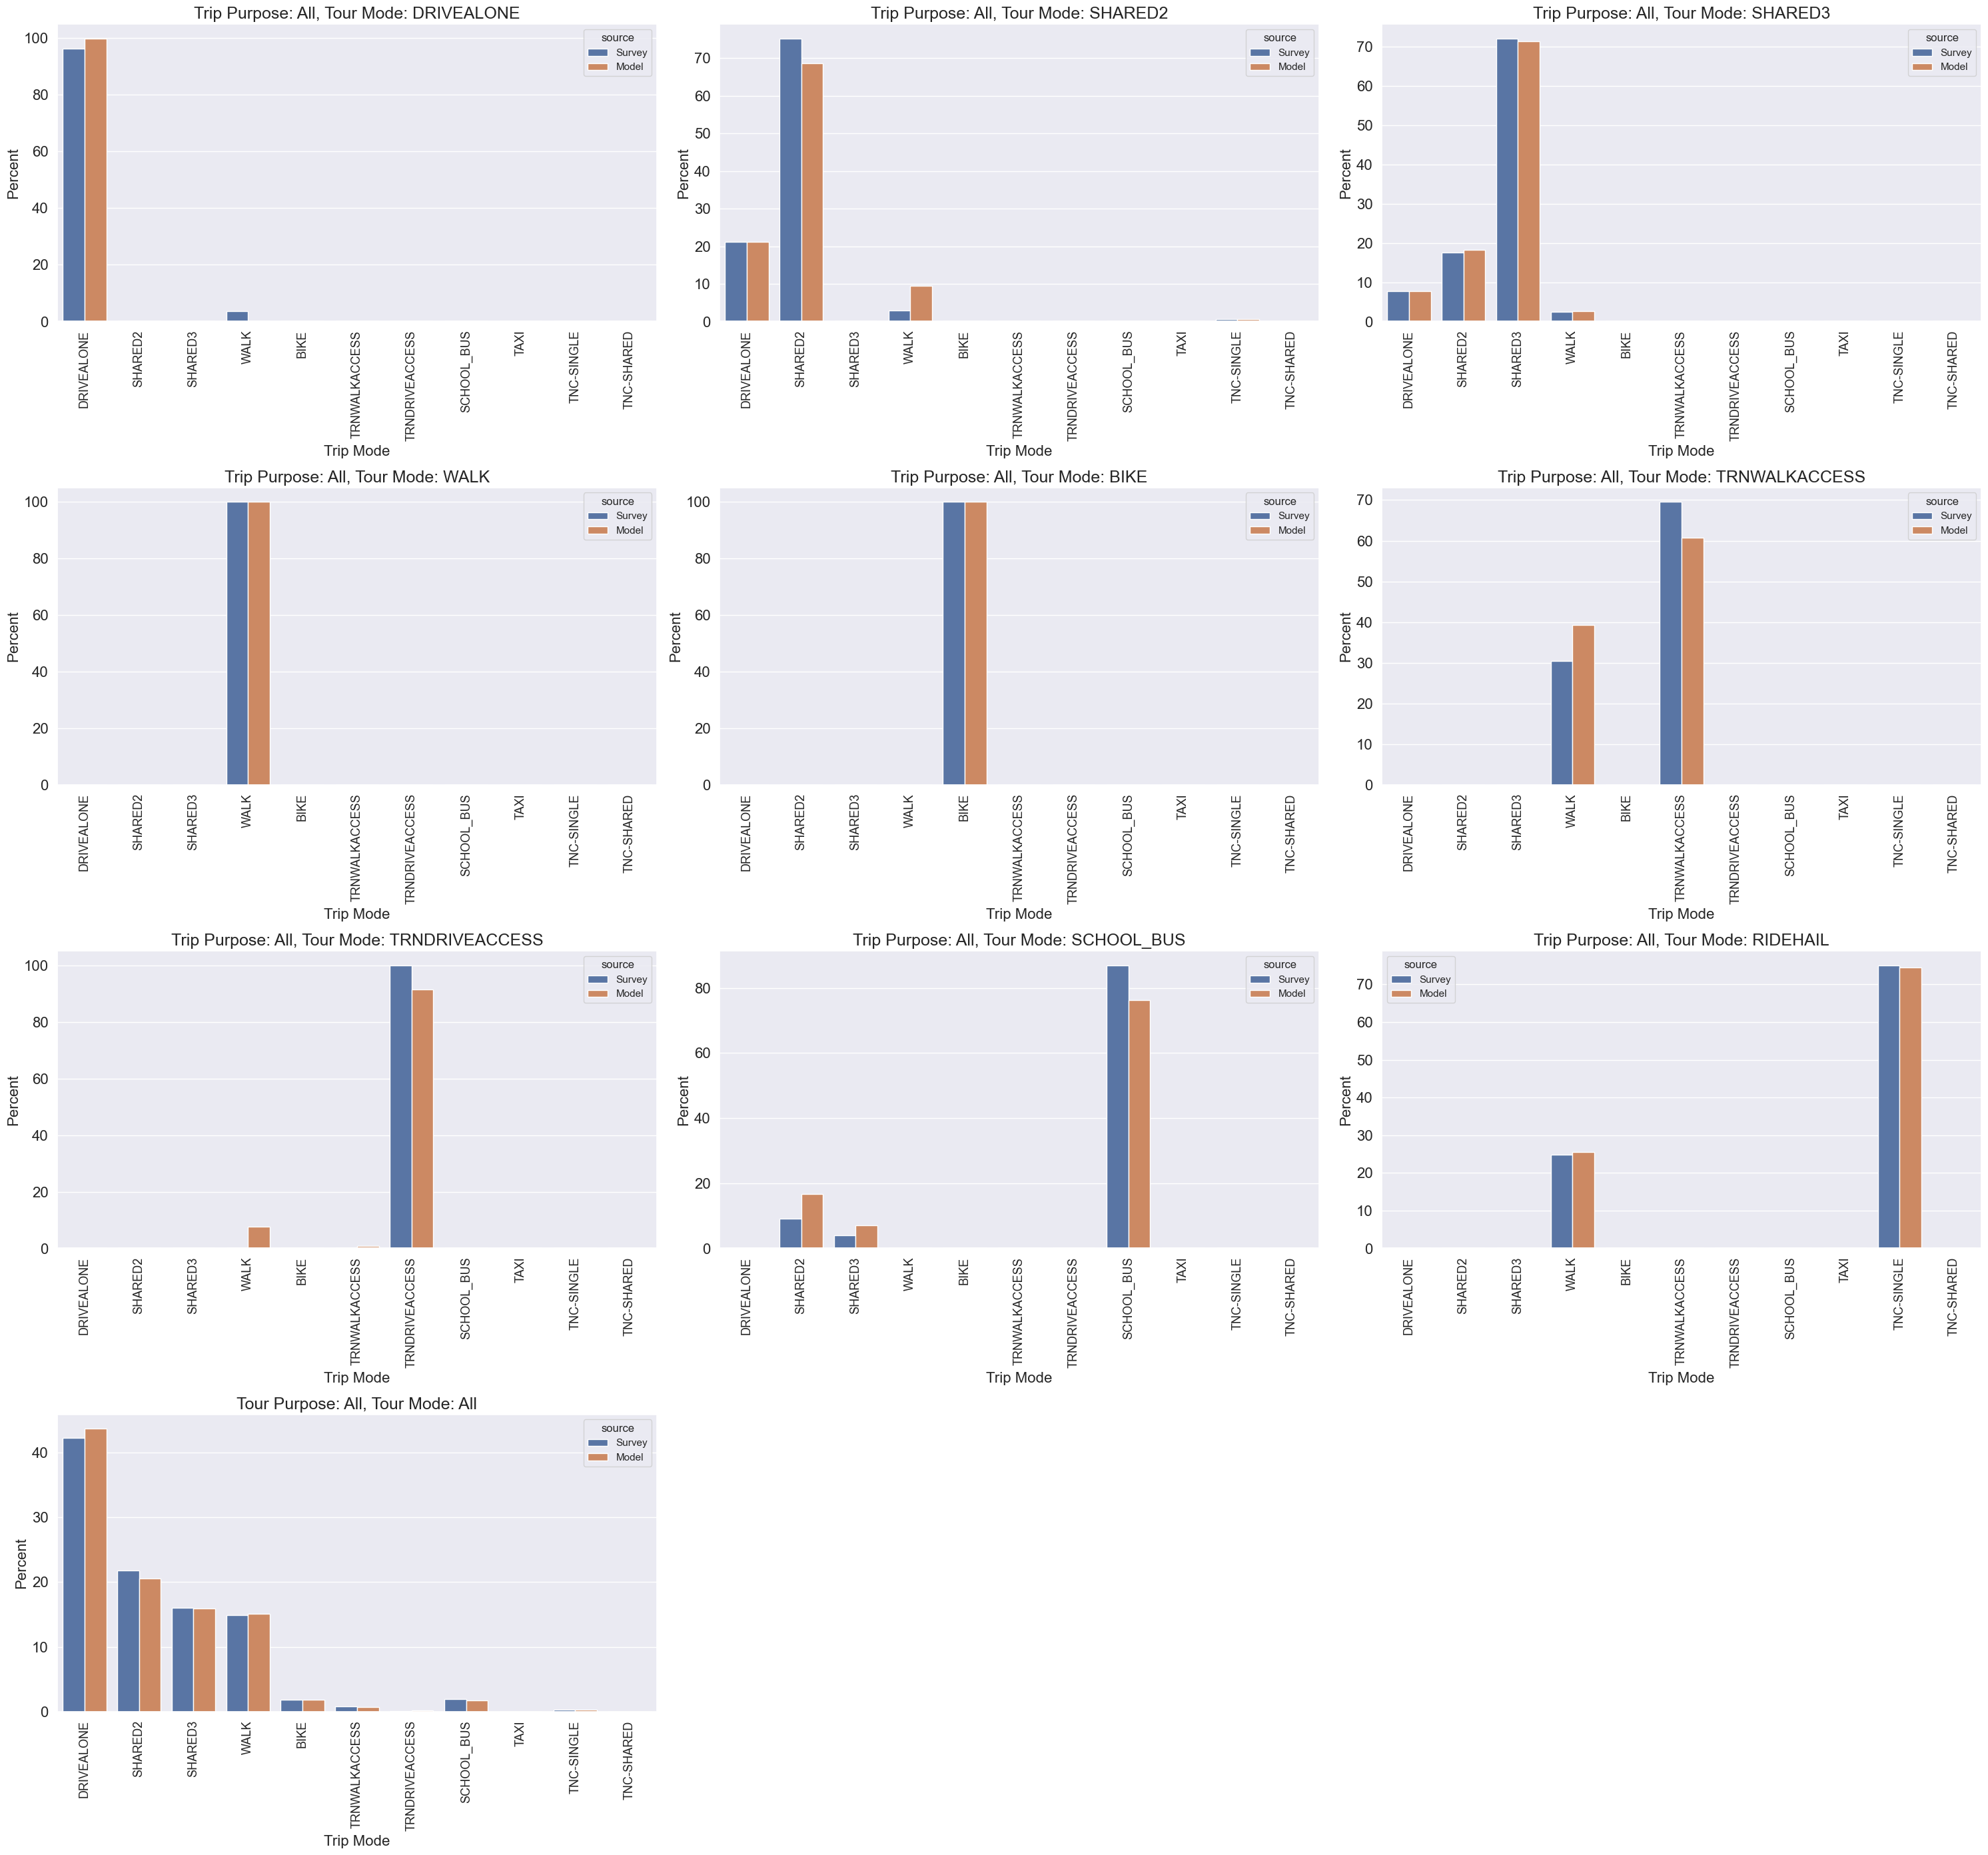

Coefficient Statistics: 
	 775 total coefficients
	 161 coefficients adjusted
	 687 coefficients converged
	 88 coefficients not converged


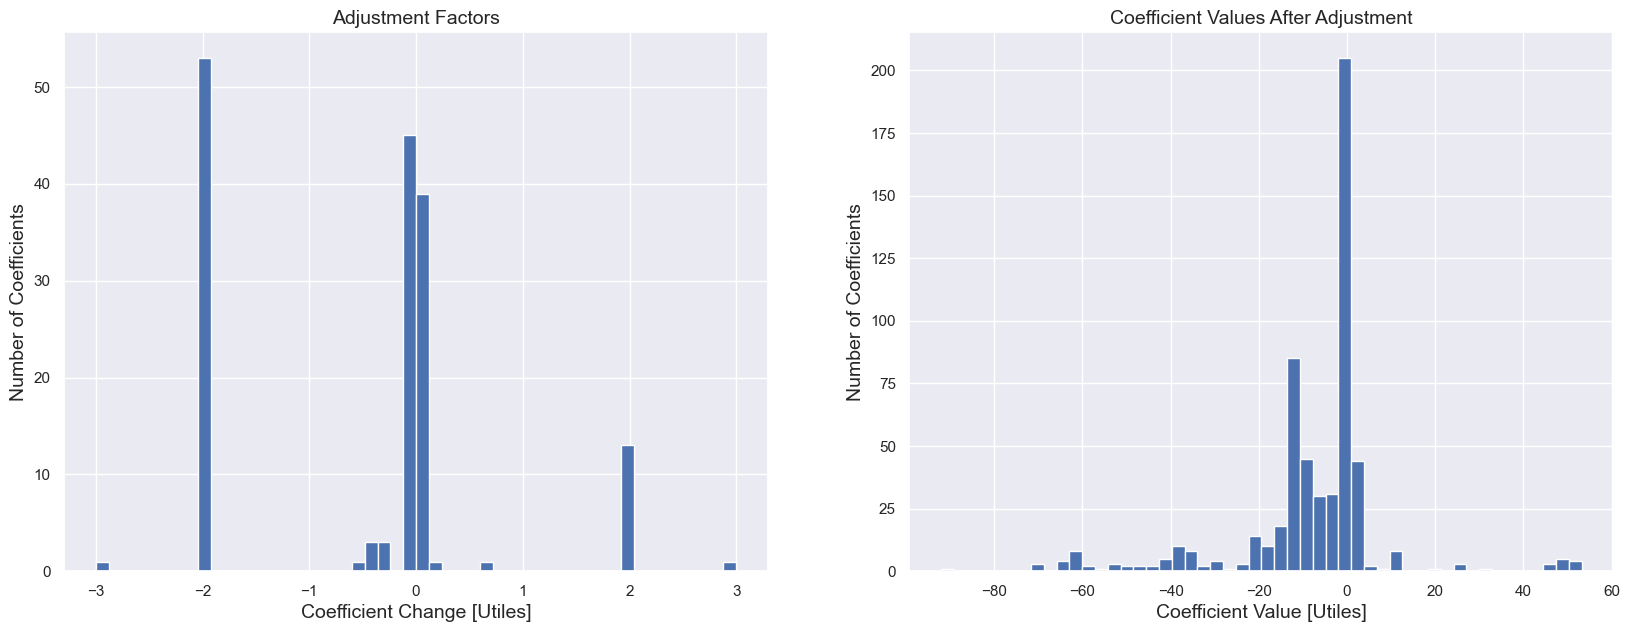

Top 10 largest coefficients:


,coefficient_name,purpose,value,scaled_model_percent,scaled_target_percent,coef_change,new_value,converged
434,coef_tnc_shared_ASC_tnc_single_univ,univ,-90.000000,97.778,0.0,-2,-92.000000,False
480,coef_joint_tnc_shared_ASC_walk_maintenance,maintenance,-68.000000,100.000,0.0,-2,-70.000000,False
475,coef_joint_tnc_single_ASC_walk_maintenance,maintenance,-68.000000,100.000,0.0,-2,-70.000000,False
470,coef_joint_taxi_ASC_walk_maintenance,maintenance,-68.000000,100.000,0.0,-2,-70.000000,False
384,coef_drive_transit_ASC_walk_work,work,-61.918780,7.629,0.0,-2,-63.918780,False
513,coef_drive_transit_ASC_walk_escort,escort,-61.052868,20.536,0.0,-2,-63.052868,False
594,coef_drive_transit_ASC_walk_othmaint,othmaint,-61.052868,20.536,0.0,-2,-63.052868,False
540,coef_drive_transit_ASC_walk_shopping,shopping,-61.052868,20.536,0.0,-2,-63.052868,False
386,coef_drive_transit_ASC_walk_transit_work,work,-60.566637,0.964,0.0,-2,-62.566637,False
596,coef_drive_transit_ASC_walk_transit_othmaint,othmaint,-60.545497,0.893,0.0,-2,-62.545497,False


,coefficient_name,value,constrain,purpose,tour_mode,trip_mode,scaled_model_percent,scaled_target_percent,difference,percent_diff,coef_change,new_value,converged,value_size
0,coef_one,1.00,T,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,1.00,True,1.00
1,coef_nest_root,1.00,T,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,1.00,True,1.00
2,coef_nest_AUTO,0.72,T,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,0.72,True,0.72
3,coef_nest_NONMOTORIZED,0.72,T,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,0.72,True,0.72
4,coef_nest_TRANSIT,0.72,T,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,0.72,True,0.72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
770,joint_sr2_ASC_rh_maint,-999.00,F,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,-999.00,True,999.00
771,joint_sr2_ASC_rh_disc,-999.00,F,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,-999.00,True,999.00
772,joint_sr2_ASC_rh_null,0.00,T,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,0.00,True,0.00
773,asc_crt,0.00,F,NaN,NaN,NaN,NaN,NaN,NaN,<NA>,<NA>,0.00,True,0.00


In [3]:
perform_trip_mode_choice_model_calibration(
        asim_output_dir=output_dir, # folder containing the activitysim model output
        asim_configs_dir=configs_dir,  # folder containing activitysim tour mode choice config files
        trip_mode_choice_calib_targets_file=trip_mode_choice_calib_targets_file,  # folder containing tour mode choice calibration tables
        max_ASC_adjust=max_ASC_adjust,  
        damping_factor=damping_factor,  # constant multiplied to all adjustments
        adjust_when_zero_counts=adjust_when_zero_counts,
        output_dir=output_dir,  # location to write model calibration steps
    )

## Initial Model Run

In [ ]:
if want_to_do_initial_model_run:
    #run_activitysim(
    #    data_dir=data_dir,  # data inputs for ActivitySim
    #    configs_dir=configs_dir,  # these files are copied to the config section of the run directory
    #    run_dir=activitysim_run_dir,  # ActivitySim run directory
    #    output_dir=output_dir,  # location to store run model outputs
    #    settings_file=cold_start_settings_mp_file,  # optional: ActivitySim settings.yaml to replace the one in configs_dir
    #    trip_mc_coef_file=trip_mc_coef_file,  # optional: tour_mode_choice_coeffs.csv to replace the one in configs_dir
    #    configs_mp_dir=configs_mp_dir  # optional: location of config files for multiprocessing
    #)
    
    _ = perform_trip_mode_choice_model_calibration(
        asim_output_dir=output_dir, # folder containing the activitysim model output
        asim_configs_dir=configs_dir,  # folder containing activitysim tour mode choice config files
        trip_mode_choice_calib_targets_file=trip_mode_choice_calib_targets_file,  # folder containing tour mode choice calibration tables
        max_ASC_adjust=max_ASC_adjust,  
        damping_factor=damping_factor,  # constant multiplied to all adjustments
        adjust_when_zero_counts=adjust_when_zero_counts,
        output_dir=output_dir,  # location to write model calibration steps
    )
    trip_mc_coef_file = os.path.join(output_dir, 'trip_mode_choice_coefficients.csv') 
else:
    print("No initial model run performed.")



## Iterating

In [ ]:
for i in range(calibration_iterations_to_run):
    iteration_output_dir = output_dir + f'_{i}'
    if not os.path.exists(iteration_output_dir):
        os.mkdir(iteration_output_dir)
        
    
    prior_path = output_dir
    if i > 0:
        prior_path = output_dir + f'_{i - 1}'

    for f in os.listdir(prior_path):
        if f[-3:] == '.h5' or f == 'breadcrumbs.yaml':
            shutil.copy (os.path.join(prior_path, f), os.path.join(iteration_output_dir, f))
    

    run_activitysim(
        data_dir=data_dir,  # data inputs for ActivitySim
        configs_dir=configs_dir,  # these files are copied to the config section of the run directory
        run_dir=activitysim_run_dir,  # ActivitySim run directory
        output_dir=iteration_output_dir,  # location to store run model outputs
        settings_file=warm_start_settings_mp_file,  # optional: ActivitySim settings.yaml to replace the one in configs_dir
        trip_mc_coef_file=trip_mc_coef_file,  # optional: tour_mode_choice_coeffs.csv to replace the one in configs_dir
        configs_mp_dir=configs_mp_dir  # optional: location of config files for multiprocessing
    )

    _ = perform_trip_mode_choice_model_calibration(
        asim_output_dir=iteration_output_dir, # folder containing the activitysim model output
        asim_configs_dir=os.path.join(activitysim_run_dir, 'configs'),  # folder containing tour mode choice config files
        trip_mode_choice_calib_targets_file=trip_mode_choice_calib_targets_file,  # folder containing tour mode choice calibration tables
        max_ASC_adjust=max_ASC_adjust,  # maximum allowed adjustment per iteration
        damping_factor=damping_factor,  # constant multiplied to all adjustments
        adjust_when_zero_counts=adjust_when_zero_counts,
        output_dir=iteration_output_dir,  # location to write model calibration steps
    )
    
    trip_mc_coef_file = os.path.join(iteration_output_dir, 'trip_mode_choice_coefficients.csv')
    iteration_output_dir = iteration_output_dir.strip('_'+str(i)) + '_' + str(i+1)

print("\n\n", "Final coefficient table written to: ", trip_mc_coef_file)